# Environment Setup

In [ ]:
# Mount to a google drive (for colab only)
from google.colab import drive
drive.mount('/content/drive')

In [1]:
# Import libraries
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import *
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
import copy
import os

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.7.1
Torchvision Version:  0.8.2


In [2]:
# setup device
print('Cuda Available:', torch.cuda.is_available())
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Cuda Available: False


In [3]:
# GPU operations have a separate seed we also want to set
if torch.cuda.is_available(): 
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    
# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

In [5]:
# set working directory
print('Original Directory:', os.getcwd())
current_dir = os.getcwd() + '/drive/Shareddrives/CSCI5525/Group_Project'
os.chdir(current_dir)
print('Current Working Directory:', current_dir)

Original Directory: /content
Current Working Directory: /content/drive/Shareddrives/CSCI5525/Group_Project


In [6]:
!pip install efficientnet_pytorch

# Crop and split data into test and train

In [ ]:
%%time
# set file directory
current_dir = os.getcwd()
working_dir = current_dir + '/dataset_test'
data_filepath = working_dir + '/images/Images/'
annotation_filepath = working_dir + '/annotations/Annotation/'

In [ ]:
%%time
# set output directory
output_dir = current_dir + '/cropped'
output_filepath = output_dir + '/images/Images/'
        
# get folder names for each class
annotation_folders = os.listdir(annotation_filepath)

# initiate classes and placeholder
n_classes = len(annotation_folders)
class_labels = []
output_size = 3
n_chnls = 256

for class_ in range(n_classes):
    # get folder names
    image_files = os.listdir(annotation_filepath+annotation_folders[class_]+'/')
    # append class labesl
    class_labels.append(annotation_folders[class_].split('-')[1])
    print('Extracting class :', annotation_folders[class_])
    
    for i in range(len(image_files)):
        img_path = annotation_folders[class_]+'/'+image_files[i]
        # get the annotations for each image
        with open(annotation_filepath+img_path) as f:
            lines = f.readlines()

        # define bounding box
        bndbox_ind = lines.index('\t\t<bndbox>\n')
        bndbox = lines[bndbox_ind+1:bndbox_ind+5]
        bndbox = [x.split('>')[1] for x in bndbox]
        bndbox = [int(x.split('<')[0]) for x in bndbox] #### x,y,w,h

        # crop the photo
        x = plt.imread(data_filepath+img_path+'.jpg')[:,:,:3]  ### Height:Width:RGB
        x = x[bndbox[1]:bndbox[3],bndbox[0]:bndbox[2],:]

        # if output direction did not exist, create
        if not os.path.exists(output_filepath+annotation_folders[class_]):
            os.makedirs(output_filepath+annotation_folders[class_])
            
        # save cropped images
        plt.imsave(output_filepath+img_path+'.jpg', x)

In [ ]:
%%time
!pip install split-folders
import splitfolders

output_filepath = os.getcwd() + '/cropped/images/Images/'

splitfolders.ratio(output_filepath, output='train_test_split', seed=1, ratio=(.8*0.8,0.8*0.2,.2))

# Transfer Learning Models

In [7]:
import torchvision.transforms.functional as F
# add square padding function
class SquarePad:
    def __call__(self, image):
        max_wh = max(image.size)
        p_left, p_top = [(max_wh - s) // 2 for s in image.size]
        p_right, p_bottom = [max_wh - (s+pad) for s, pad in zip(image.size, [p_left, p_top])]
        padding = (p_left, p_top, p_right, p_bottom)
        return F.pad(image, padding, 0, 'constant')

In [4]:
%%time
# Initiate data directory and batch size
data_dir = os.getcwd() + '/train_test_split'
batch_size = 64
im_size = (224,224)

# Define data transformation
data_transforms = {
    # Data augmentation and normalization for training
    'train': transforms.Compose([
        transforms.Resize(im_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # Just normalization for validation
    'val': transforms.Compose([
        transforms.Resize(im_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # Just normalization for testing
    'test': transforms.Compose([
        transforms.Resize(im_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print('Initializing Datasets and Dataloaders')
print('---------------------------------------')

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}

# Define classes
classes = image_datasets['train'].classes
classes = [c.split('-')[1] for c in classes]
num_classes = len(classes)
print('no. of classes found =', num_classes)

# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=1) for x in ['train', 'val', 'test']}

Initializing Datasets and Dataloaders
---------------------------------------
no. of classes found = 120
CPU times: user 70.1 ms, sys: 38.9 ms, total: 109 ms
Wall time: 125 ms


In [5]:
%%time
from torch.utils.tensorboard import SummaryWriter
from display_tensorboard import *

# default tensorboard 
writer = SummaryWriter('runs/dogs')
# Writing to tensorboard to display some random training images
images, labels = next(iter(dataloaders_dict['train']))
img_grid = torchvision.utils.make_grid(images) # create grid of images
writer.add_image('dogs_images', img_grid)

# # Adding a “Projector” to TensorBoard - log embeddings
# im, lab = images[:,1], labels
# class_labels = [classes[lab] for lab in lab]
# features = im.view(-1, 224 * 224)
# writer.add_embedding(features[:,60], metadata=class_labels, label_img=images.unsqueeze(1))
# writer.close()

CPU times: user 918 ms, sys: 160 ms, total: 1.08 s
Wall time: 7.27 s


In [6]:
%%time
from transfer_learning import *
import torch
from torch.utils.tensorboard import SummaryWriter # TensorBoard support
# Load the TensorBoard notebook extension
%load_ext tensorboard


num_epochs = 40
#models = ['alexnet']
models = ['googlenet', 'alexnet', 'vgg', 'resnet', 'efficientnet']
feature_extract = [True, False]
performance = pd.DataFrame(columns=['model','feature_extract','epoch','run_time','train_loss','train_acc','val_loss','val_acc'], index=None)
test_acc_dict = {}

for fe in feature_extract:
    for m in models:

        print('==================================================')
        print(f'Model : {m} with feature_extract = {fe}')
        print('==================================================')

        # initiate model
        model = transfer_learning(dataloaders_dict, classes=classes, model=m, feature_extract=fe, num_epochs=num_epochs, batch_size=batch_size)
        # train model
        _, model_performance = model.train()
        performance = performance.append(model_performance, ignore_index=True)
        # get test accuracy
        test_acc = model.test()
        test_acc_dict[f'{m}-{fe*1.0}'] = test_acc
        print(f'Test accuracy: {test_acc:.2%}')
        

Model : googlenet with feature_extract = True
number of classes: 120
device: cpu
parameters to learn:
--------------------
	 fc.weight
	 fc.bias


Epoch 1/5
----------
Error: unable to plot model graph
train loss: 2.5774 accuracy: 48.15%
val loss: 1.4148 accuracy: 69.72%
Epoch completed in 19m 44s

Epoch 2/5
----------
train loss: 1.2360 accuracy: 70.83%
val loss: 1.0601 accuracy: 72.77%
Epoch completed in 19m 41s

Epoch 3/5
----------
train loss: 0.9780 accuracy: 74.60%
val loss: 0.9621 accuracy: 73.29%
Epoch completed in 19m 37s

Epoch 4/5
----------
train loss: 0.8595 accuracy: 77.05%
val loss: 0.8601 accuracy: 75.14%
Epoch completed in 19m 41s

Epoch 5/5
----------
train loss: 0.7778 accuracy: 78.63%
val loss: 0.8454 accuracy: 75.17%
Epoch completed in 19m 40s


Training complete in 98m 23s
Best val Acc: 75.17%
Test accuracy: 74.30%
Model : alexnet with feature_extract = True
number of classes: 120
device: cpu
parameters to learn:
--------------------
	 classifier.6.weight
	 classifier.6.bias


Epoch 1/5
----------
train loss: 1.9680 accuracy: 49.25%
val loss: 1.3509 accuracy: 60.04%
Epoch completed in 5m 30s

Epoch 2/5
----------
train loss: 0.9916 accuracy: 70.19%
val loss: 1.2845 accuracy: 63.56%
Epoch completed in 5m 22s

Epoch 3/5
----------
train loss: 0.7219 accuracy: 76.86%
val loss: 1.3007 accuracy: 64.85%
Epoch completed in 5m 23s

Epoch 4/5
----------
train loss: 0.5809 accuracy: 80.93%
val loss: 1.3199 accuracy: 65.13%
Epoch completed in 5m 22s

Epoch 5/5
----------
train loss: 0.4874 accuracy: 83.45%
val loss: 1.3703 accuracy: 65.74%
Epoch completed in 5m 22s


Training complete in 27m 1s
Best val Acc: 65.74%
Test accuracy: 62.67%
Model : vgg with feature_extract = True
number of classes: 120
device: cpu


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/py/.cache/torch/hub/checkpoints/vgg16-397923af.pth



parameters to learn:
--------------------
	 classifier.6.weight
	 classifier.6.bias


Epoch 1/5
----------
train loss: 1.0115 accuracy: 71.72%
val loss: 0.5561 accuracy: 81.92%
Epoch completed in 115m 12s

Epoch 2/5
----------
train loss: 0.5637 accuracy: 81.97%
val loss: 0.5276 accuracy: 82.84%
Epoch completed in 112m 51s

Epoch 3/5
----------
train loss: 0.4853 accuracy: 84.23%
val loss: 0.5143 accuracy: 83.46%
Epoch completed in 113m 3s

Epoch 4/5
----------
train loss: 0.4411 accuracy: 85.60%
val loss: 0.5356 accuracy: 83.18%
Epoch completed in 122m 43s

Epoch 5/5
----------
train loss: 0.4120 accuracy: 86.36%
val loss: 0.5635 accuracy: 82.90%
Epoch completed in 123m 34s


Training complete in 587m 22s
Best val Acc: 83.46%
Test accuracy: 82.63%
Model : resnet with feature_extract = True
number of classes: 120
device: cpu
parameters to learn:
--------------------
	 fc.weight
	 fc.bias


Epoch 1/5
----------
train loss: 2.4521 accuracy: 48.63%
val loss: 1.3079 accuracy: 70.73%
Epoch completed in 16m 19s

Epoch 2/5
----------
train loss: 1.0885 accuracy: 74.56%
val loss: 0.9477 accuracy: 74.68%
Epoch completed in 16m 43s

Epoch 3/5
----------
train loss: 0.8312 accuracy: 78.68%
val loss: 0.8505 accuracy: 75.79%
Epoch completed in 16m 42s

Epoch 4/5
----------
train loss: 0.7168 accuracy: 81.09%
val loss: 0.7950 accuracy: 76.71%
Epoch completed in 16m 17s

Epoch 5/5
----------
train loss: 0.6393 accuracy: 82.58%
val loss: 0.7751 accuracy: 75.91%
Epoch completed in 16m 8s


Training complete in 82m 8s
Best val Acc: 76.71%
Test accuracy: 76.01%
Model : efficientnet with feature_extract = True
number of classes: 120
device: cpu
parameters to learn:
--------------------
	 _fc.weight
	 _fc.bias


Epoch 1/5
----------
train loss: 4.9618 accuracy: 1.18%
val loss: 4.7879 accuracy: 1.23%
Epoch completed in 111m 53s

Epoch 2/5
----------



KeyboardInterrupt: 

In [7]:
%tensorboard --logdir runs

Reusing TensorBoard on port 6007 (pid 23771), started 16:14:46 ago. (Use '!kill 23771' to kill it.)

In [8]:
performance

,model,feature_extract,epoch,run_time,train_loss,train_acc,val_loss,val_acc,converged
0,googlenet,True,1,1184.476434,2.577450,0.481493,1.414774,0.697166,0.0
1,googlenet,True,2,1180.621410,1.235955,0.708274,1.060120,0.727665,1.0
2,googlenet,True,3,1177.142858,0.978006,0.745960,0.962144,0.732902,1.0
3,googlenet,True,4,1181.168348,0.859533,0.770537,0.860097,0.751386,1.0
4,googlenet,True,5,1179.991764,0.777798,0.786326,0.845362,0.751694,1.0
5,alexnet,True,1,330.295333,1.967971,0.492515,1.350925,0.600431,0.0
6,alexnet,True,2,322.322313,0.991619,0.701944,1.284476,0.635551,1.0
7,alexnet,True,3,323.258685,0.721932,0.768601,1.300697,0.648490,0.0
8,alexnet,True,4,322.256602,0.580926,0.809265,1.319944,0.651263,0.0
9,alexnet,True,5,322.449264,0.487434,0.834513,1.370343,0.657425,0.0


In [ ]:
test_acc_dict

# Data Visualization

In [9]:
# unpivot performance dataframe
performance.feature_extract = performance.feature_extract*1.0
col = performance.columns
loss = performance.melt(id_vars=set(col)-set(['train_loss', 'val_loss']), var_name='phase', value_name='loss')
loss.phase = loss.phase.str.replace('_loss', '', regex=False)

acc = performance.melt(id_vars=set(col)-set(['train_acc', 'val_acc']), var_name='phase', value_name='accuracy')
acc.phase = acc.phase.str.replace('_acc', '', regex=False)
unp = loss[['model', 'feature_extract', 'epoch', 'phase', 'run_time', 'loss']].merge(acc[['model', 'feature_extract', 'epoch', 'phase', 'accuracy']], on=['model', 'feature_extract', 'epoch', 'phase'])
unp

,model,feature_extract,epoch,phase,run_time,loss,accuracy
0,googlenet,1,1,train,1184.476434,2.577450,0.481493
1,googlenet,1,2,train,1180.621410,1.235955,0.708274
2,googlenet,1,3,train,1177.142858,0.978006,0.745960
3,googlenet,1,4,train,1181.168348,0.859533,0.770537
4,googlenet,1,5,train,1179.991764,0.777798,0.786326
5,alexnet,1,1,train,330.295333,1.967971,0.492515
6,alexnet,1,2,train,322.322313,0.991619,0.701944
7,alexnet,1,3,train,323.258685,0.721932,0.768601
8,alexnet,1,4,train,322.256602,0.580926,0.809265
9,alexnet,1,5,train,322.449264,0.487434,0.834513


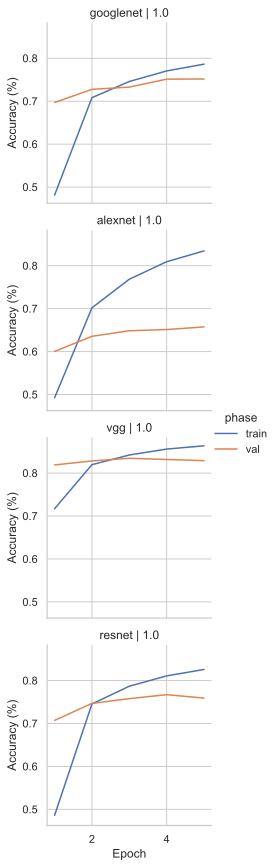

In [10]:
# plot training and validation accuracy
sns.set_style("whitegrid")
g = sns.FacetGrid(unp, row='model', col='feature_extract', hue='phase')
g.map_dataframe(sns.lineplot, x='epoch', y='accuracy')
g.add_legend()
g.set_axis_labels('Epoch', 'Accuracy (%)')
g.set_titles(col_template='{col_name}', row_template='{row_name}')

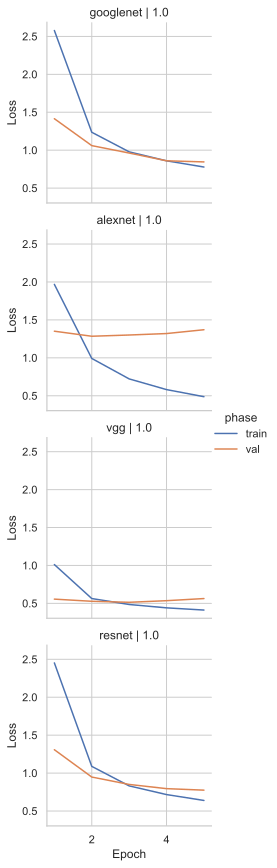

In [11]:
# plot training and validation loss
g = sns.FacetGrid(unp, row='model', col='feature_extract', hue='phase')
g.map_dataframe(sns.lineplot, x='epoch', y='loss')
g.add_legend()
g.set_axis_labels('Epoch', 'Loss')
g.set_titles(col_template='{col_name}', row_template='{row_name}')

<AxesSubplot:xlabel='feature_extract', ylabel='run_time'>

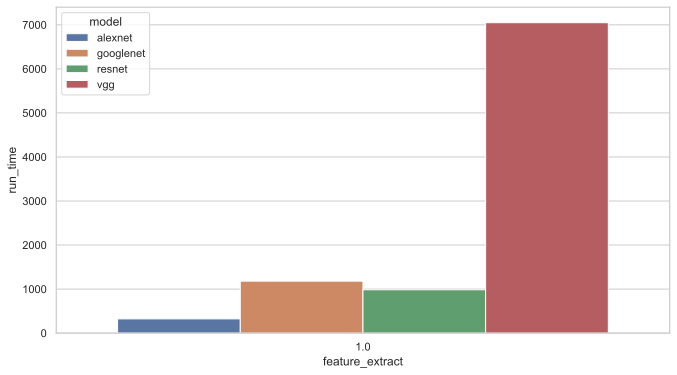

In [12]:
# plot training runtime
sns.set(rc={'figure.figsize':(11,6)})
sns.set_style("whitegrid")

temp = unp[unp.phase=='train'].groupby(by=['model', 'feature_extract']).agg({'run_time':'mean'}).reset_index()
sns.barplot(data=temp, x='feature_extract', y='run_time', hue='model')

In [16]:
# test - evaluation plot accuracy
# # parameters vs time to converge
  # - how do we define convergence? -> epoch > 20 and (pre val loss - current loss < 0.0001)

1